In [ ]:
import torch
from transformers import pipeline, T5Tokenizer, T5ForConditionalGeneration
from sentence_transformers import SentenceTransformer
from datasets import Dataset
import numpy as np
from typing import List, Dict
import faiss
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
from openai import OpenAI
import dotenv
import os

os.chdir('./RAG')
torch.cuda.get_device_name()

/common/home/projectgrps/IS424/IS424G4/jupyterlab-venv-pytorch-240/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'NVIDIA GeForce RTX 3090'

## RAG

In [3]:
def summarize_news(
    texts: list[str],
    model_name: str = "google/flan-t5-base",
    max_length: int = 128,
    batch_size: int = 8
) -> list[str]:
    """
    Summarize long news articles into concise descriptions
    
    Args:
        texts: List of news articles
        model_name: Name of the T5 model to use
        max_length: Maximum length of each summary
        batch_size: Batch size for processing
    
    Returns:
        List of summarized texts
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    tokenizer = T5Tokenizer.from_pretrained(model_name)
    model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)
    
    summaries = []
    
    # Process in batches
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        
        # Create prompts
        prompts = [
            f"summarize this maritime incident: {text}"
            for text in batch_texts
        ]
        
        # Tokenize
        inputs = tokenizer(
            prompts,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors="pt"
        ).to(device)
        
        # Generate summaries
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_length=max_length,
                num_beams=4,
                temperature=0.7,
                early_stopping=True
            )
        
        # Decode summaries
        batch_summaries = tokenizer.batch_decode(
            outputs,
            skip_special_tokens=True
        )
        summaries.extend(batch_summaries)
    
    return summaries
    
class MaritimeRiskRAG:
    def __init__(
        self,
        encoder_model="sentence-transformers/all-mpnet-base-v2",
        generator_model="google/flan-t5-base",
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        """
        Initialize RAG system with Hugging Face models
        
        Args:
            encoder_model: Model to use for encoding text into embeddings
            generator_model: Model to use for generating summaries and categories
            device: Device to run models on (cuda or cpu)
        """
        self.device = device
            
        # Initialize sentence encoder
        self.encoder = SentenceTransformer(encoder_model).to(device)
        
        # Initialize generator
        self.generator_model = generator_model
        if 'gpt' in self.generator_model:
            self.OPENAI_API_KEY = dotenv.get_key('.env', 'OPENAI_API_KEY')
            self.client = OpenAI(api_key=self.OPENAI_API_KEY)
        else:
            self.generator = pipeline(
                "text2text-generation",
                model=generator_model,
                device=0 if device == "cuda" else -1
            )
        
        # Initialize FAISS index for similarity search
        self.index = None
        self.texts = None
        
    def encode_texts(self, texts: List[str]) -> np.ndarray:
        """
        Encode texts into embeddings
        """
        embeddings = self.encoder.encode(
            texts,
            batch_size=32,
            show_progress_bar=True,
            convert_to_numpy=True
        )
        return embeddings
    
    def build_index(self, texts: List[str]):
        """
        Build FAISS index from text embeddings
        """
        self.texts = texts
        embeddings = self.encode_texts(texts)
        
        # Initialize FAISS index
        dimension = embeddings.shape[1]
        self.index = faiss.IndexFlatL2(dimension)
        
        # Add embeddings to index
        self.index.add(embeddings.astype('float32'))
        
    def retrieve_similar(
        self,
        query: str,
        k: int = 5
    ) -> List[Dict[str, any]]:
        """
        Retrieve similar texts for a query
        """
        # Encode query
        query_embedding = self.encode_texts([query])
        
        # Search index
        distances, indices = self.index.search(
            query_embedding.astype('float32'),
            k
        )
        
        # Return results
        results = []
        for distance, idx in zip(distances[0], indices[0]):
            results.append({
                'text': self.texts[idx],
                'distance': distance,
                'index': int(idx)
            })
            
        return results
    
    def generate_category(self, texts: List[str], filter_others: bool) -> str:
        """
        Generate a risk category description from similar texts
        """
        # Combine texts
        combined_text = " ".join(texts)
        
        example_categories = [
            "Vessel Delay",
            "Vessel Accidents",
            "Piracy",
            "Route Congestion",
            "Port Criminal Activity",
            "Cargo Damage and Loss",
            "Inland Transportation Risk",
            "Environmental Impact and Pollution",
            "Extreme Weather",
            "Cargo Detainment"
        ]

        # Generate prompt
        if filter_others:
            prompt = f"""
            You are a maritime risk analysis assistant. Below is a list of common maritime risk categories (do NOT use any of these):
            {", ".join(example_categories)}
            
            The following incidents have already been analyzed and do not fit any of the example categories:
            "{combined_text}"
            
            Based on this, generate the most suitable risk category for these incidents. Do NOT use any of the listed categories. Instead, create a unique risk category that most accurately captures the nature of these incidents. Please provide only a single category.
            
            Risk Category:
            """
        else:
            prompt = f"""
            You are a maritime risk analysis assistant. Below is a list of common maritime risk categories:
            {", ".join(example_categories)}
            
            Based on the recent maritime incidents described here:
            "{combined_text}"
            
            Generate the most suitable risk category for these incidents. Use one of the listed categories if it is a good fit, or create a new, more suitable category if none of the examples fully applies. Please only provide a single category.
            
            Risk Category:
            """
        
        # Generate category
        if 'gpt' in self.generator_model:
            response = self.client.chat.completions.create(
                model=self.generator_model,
                messages=[
                    {"role": "system", "content": "You are a specialized assistant in maritime risk analysis, providing concise and accurate risk categories."},
                    {"role": "user", "content": prompt}
                ],
                max_tokens=100,
                temperature=0.1
            ).choices[0].message.content
        else:
            response = self.generator(
                prompt,
                max_length=100,
                num_return_sequences=1
            )[0]['generated_text']
        
        return response
    
    def find_optimal_k(
        self,
        embeddings: np.ndarray,
        k_range: range = range(2, 21),
        method: str = 'both'
    ):
        """
        Find optimal number of clusters using both elbow method and silhouette analysis
        
        Args:
            embeddings: Document embeddings
            k_range: Range of k values to try
            method: One of 'elbow', 'silhouette', or 'both'
            
        Returns:
            Tuple of (optimal k, metrics dictionary)
        """
        inertias = []
        silhouette_scores = []
        
        for k in k_range:
            # Train KMeans
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(embeddings)
            
            # Calculate metrics
            inertias.append(kmeans.inertia_)
            if k > 2:  # Silhouette score needs at least 2 clusters
                silhouette_scores.append(
                    silhouette_score(embeddings, kmeans.labels_)
                )
            else:
                silhouette_scores.append(0)
                
        # Find elbow point
        elbow_locator = KneeLocator(
            list(k_range),
            inertias,
            curve='convex',
            direction='decreasing'
        )
        elbow_k = elbow_locator.knee
        
        # Find best silhouette score
        best_silhouette_k = k_range[np.argmax(silhouette_scores)]
        
        # Store metrics
        metrics = {
            'k_range': list(k_range),
            'inertias': inertias,
            'silhouette_scores': silhouette_scores,
            'elbow_k': elbow_k,
            'best_silhouette_k': best_silhouette_k
        }
        
        # Choose optimal k based on method
        if method == 'elbow':
            optimal_k = elbow_k
        elif method == 'silhouette':
            optimal_k = best_silhouette_k
        else:  # both
            # Average the two methods, rounding to nearest integer
            optimal_k = round((elbow_k + best_silhouette_k) / 2)
            
        return optimal_k, metrics
    
    def plot_clustering_metrics(self, metrics: Dict):
        """
        Plot elbow curve and silhouette scores
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot elbow curve
        ax1.plot(metrics['k_range'], metrics['inertias'])
        ax1.set_xlabel('Number of clusters (k)')
        ax1.set_ylabel('Inertia')
        ax1.set_title('Elbow Method')
        if metrics['elbow_k']:
            ax1.axvline(x=metrics['elbow_k'], color='r', linestyle='--')
            ax1.text(metrics['elbow_k'], max(metrics['inertias'])/2,
                    f'Elbow point: k={metrics["elbow_k"]}')
            
        # Plot silhouette scores
        ax2.plot(metrics['k_range'], metrics['silhouette_scores'])
        ax2.set_xlabel('Number of clusters (k)')
        ax2.set_ylabel('Silhouette Score')
        ax2.set_title('Silhouette Analysis')
        ax2.axvline(x=metrics['best_silhouette_k'], color='r', linestyle='--')
        ax2.text(metrics['best_silhouette_k'],
                max(metrics['silhouette_scores'])/2,
                f'Best k={metrics["best_silhouette_k"]}')
        
        plt.tight_layout()
        return fig
    
    def discover_risk_categories(
        self,
        data: pd.DataFrame,
        k_range: range = range(2, 21),
        method: str = 'both',
        filter_others: bool = False,
        samples_per_cluster: int = 30
    ) -> List[Dict[str, any]]:
        """
        Discover risk categories from texts using RAG
        """
        
        # Filter to only "Others" category'
        if filter_others:
            data = data[data['Final Classification'] == "Others"]
        texts = data['Disruption event'].tolist()

        # Build index if not already built
        if self.index is None:
            self.build_index(texts)

        # Convert texts to dataset
        dataset = Dataset.from_dict({'text': texts})
        
        # Get embeddings for all texts
        embeddings = self.encode_texts(texts)

        # Find optimal number of clusters
        optimal_k, metrics = self.find_optimal_k(embeddings, k_range, method)
        
        # Plot metrics
        self.plot_clustering_metrics(metrics)

        # Perform k-means clustering
        kmeans = KMeans(n_clusters=optimal_k, random_state=42)
        clusters = kmeans.fit_predict(embeddings)

        # Generate categories for each cluster
        categories = []
        for i in range(optimal_k):
            # Get texts from cluster
            cluster_texts = [
                text for text, cluster in zip(texts, clusters)
                if cluster == i
            ]
            
            # Skip if cluster is empty
            if not cluster_texts:
                continue
            
            # Sample texts for category generation
            n = min(samples_per_cluster, len(cluster_texts))
            sampled_texts = cluster_texts[:n]
            
            # Generate category
            category = self.generate_category(sampled_texts, filter_others)
            
            # Add to categories
            categories.append({
                'category': category,
                'sample_texts': sampled_texts,
                'size': len(cluster_texts)
            })
            
        return categories, clusters
    
    def analyze_new_incident(
        self,
        incident_text: str,
        k: int = 5
    ) -> Dict[str, any]:
        """
        Analyze a new incident by comparing it to existing incidents
        """
        # Retrieve similar incidents
        similar = self.retrieve_similar(incident_text, k)
        
        # Generate category for the incident
        category = self.generate_category(
            [incident_text] + [s['text'] for s in similar]
        )
        
        return {
            'suggested_category': category,
            'similar_incidents': similar
        }

def format_risk_analysis(categories: List[Dict[str, any]]) -> pd.DataFrame:
    """
    Format risk categories into a DataFrame
    """
    rows = []
    for cat in categories:
        rows.append({
            'Category': cat['category'],
            'Number of Incidents': cat['size'],
            'Example Incidents': '\n'.join(cat['sample_texts'][:3])
        })
    
    return pd.DataFrame(rows)

Batches: 100%|██████████| 19/19 [00:00<00:00, 70.38it/s]


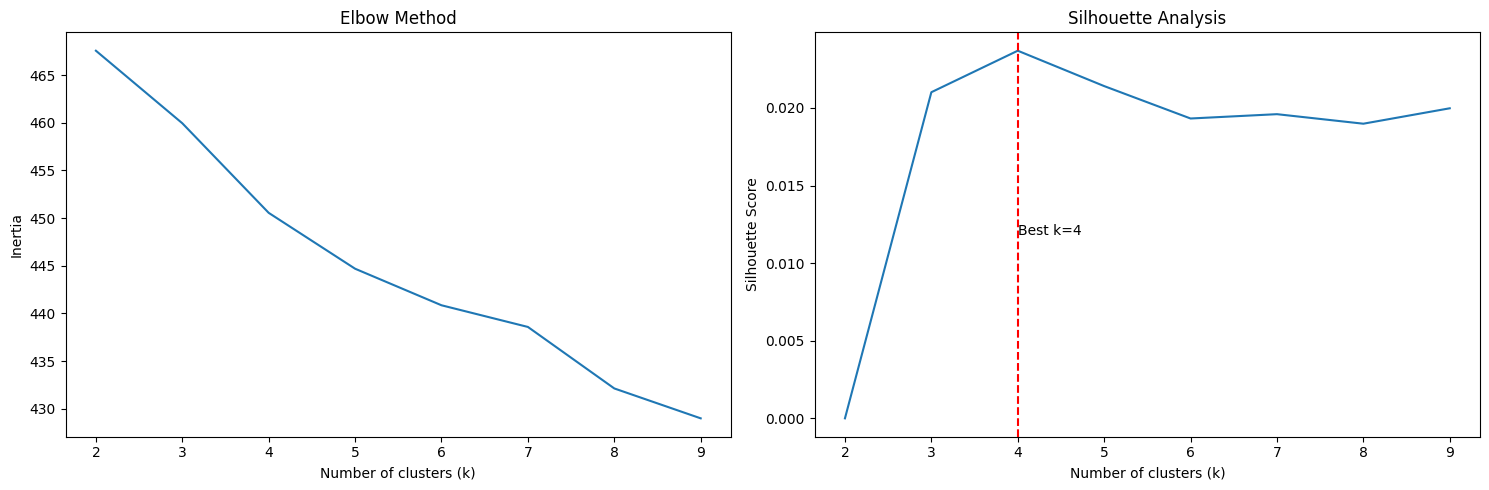

In [4]:
# Initialize RAG system
rag = MaritimeRiskRAG(
    generator_model="gpt-4o-mini"
)

# Example texts (replace with your actual data)
filename = 'data_new.xlsx'
data = pd.read_excel(filename, index_col=0)

# # Summarize news articles
# texts = summarize_news(texts)
# print("Texts summarized")

# Discover risk categories
categories, clusters = rag.discover_risk_categories(
    data,
    k_range=range(2, 10),
    method='silhouette',
    filter_others=True
)

# Format and display results
results_df = format_risk_analysis(categories)
# print(results_df)

# # Analyze a new incident
# new_incident = data['Cleaned_Description'].sample(1).tolist()
# analysis = rag.analyze_new_incident(new_incident)
# print("\nNew Incident Analysis:")
# print(f"Suggested Category: {analysis['suggested_category']}")
# print("\nSimilar Past Incidents:")
# for incident in analysis['similar_incidents']:
#     print(f"- {incident['text']}")

In [30]:
from collections import Counter
cluster_names = results_df['Category'].tolist()
classes = list(map(lambda x: cluster_names[x], clusters))

counts = Counter(classes)
display(counts)

Counter({'Operational and Strategic Development Risks': 177,
         'Market and Operational Disruption Risk': 158,
         'Cybersecurity and Geopolitical Threats': 156,
         'Regulatory and Technological Transition Risk': 104})

In [ ]:
data_copy = data.copy()
data_copy.loc[data_copy['Final Classification'] == 'Others', 'Final Classification'] = list(map(lambda x: cluster_names[x], clusters))

In [24]:
data_copy['Final Classification'].value_counts()

Final Classification
Vessel Accidents                                 731
Port or Important Route Congestion               626
Maritime Piracy/Terrorism Risk                   567
Unstable Regulatory and Political Environment    417
Environmental Impact and Pollution               303
Not maritime-related                             258
Port Criminal Activities                         226
Inland Transportation Risks                      209
Cargo or Ship Detainment                         182
Operational and Strategic Development Risks      177
Market and Operational Disruption Risk           158
Cybersecurity and Geopolitical Threats           156
Natural Extreme Events and Extreme Weather       139
Vessel Delay                                     138
Regulatory and Technological Transition Risk     104
Cargo Damage and Loss                             32
Name: count, dtype: int64

In [36]:
data_copy[data_copy['Final Classification'] == 'Operational and Strategic Development Risks']['Disruption event'].sample(10).tolist()

["The Bureau of Ocean Energy Management (BOEM) has approved Avangrid's New England Wind Construction and Operations Plan.",
 'Rolls-Royce opened a new Research & Development Centre for Autonomous Ships.',
 'W rtsil is providing a simulator for inland shipping training in Duisburg, Germany.',
 'A successful test run of an autonomous ship collision avoidance system was conducted.',
 'Rapid growth in offshore wind poses risks and challenges, including cable damage, collisions, and environmental concerns.',
 'The opening of a new deep-water berth at the New Bedford Foss Marine Terminal.',
 'ABB has won an order to equip 15 LNG carriers with permanent magnet shaft generator technology.',
 'Equinor will implement a new area-wide emergency preparedness system.',
 "The launch of the world's first automated containership.",
 'WISTA Cyprus announced it will host the 2024 WISTA International AGM and Conference.']

In [ ]:
data_copy.to_excel('data_new_categories.xlsx')